# Identifying drifting GO terms in PMID26623667

Tong Shu Li

## Objective

To identify GO terms in PMID26623667 which increase in drift over time, but are reduced by mianserin treatment. To make the problem more tractable, Michael set forth some conditions about the GO terms. The GO terms we will examine should:

1. Have 10 to 500 genes
    - We want to examine GO terms with a reasonable number of genes so that we can cheaply sequence them. However, too few genes would make the drift estimates less reliable. This range is arbitrary.
2. Not belong to the "molecular_function" family
    - We expect genes belonging to this family of GO terms to drift erratically

## Plan

1. Read GO annotations for *C. elegans*.
2. Determine GO terms with 10 to 500 genes sequenced in PMID26623667.
3. Calculate drift for each GO term, and fit linear regressions.
4. Examine regressions and look for the best results.

In [1]:
import numpy as np
import pandas as pd
import rpy2.robjects as robj
import seaborn as sns
import sys

from collections import defaultdict
from itertools import chain
from tqdm import tqdm

In [2]:
sys.path.append("../..")

In [3]:
from src.gene_ont import group_genes
from src.gene_ont import load_annotations
from src.gene_ont import parse_go_defn
from src.gene_ont import parse_go_links

In [4]:
%matplotlib inline
%load_ext rpy2.ipython

In [5]:
%%R

sessionInfo()

R version 3.3.0 (2016-05-03)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: Fedora 23 (Workstation Edition)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     


---

## Read filtered transcriptome data

1. Read the entire dataset.
2. Filter down to the timeseries data with sample 6, replicate 2 removed (an outlier).

In [6]:
data = (pd
    .read_csv("../../data/PMID26623667/clean_annotated_cpm_values.tsv", sep = '\t')
    .query("cohort <= 7 & samples != 62")
    .assign(log_day = lambda df: np.log(df["day_harvested"]))
    .rename(columns = {"wormbaseid": "wormbase_id"})
    .replace("water", "control")
)

In [7]:
data.shape

(217580, 14)

In [8]:
data.head()

,seqname,samples,cpm_value,cohort,replicate,day_harvested,drug,drug_conc_uM,day_drug_added,youngref_cpm,RLFEC,wormbase_id,gene_symbol,log_day
0,2RSSE.1,11,4.55942,1,1,1,control,0,1,4.105726,0.104814,WBGene00007064,2RSSE.1,0.000000
1,2RSSE.1,12,3.21332,1,2,1,control,0,1,4.105726,-0.245078,WBGene00007064,2RSSE.1,0.000000
2,2RSSE.1,13,4.54444,1,3,1,control,0,1,4.105726,0.101521,WBGene00007064,2RSSE.1,0.000000
3,2RSSE.1,21,11.43680,2,1,3,control,0,1,4.105726,1.024454,WBGene00007064,2RSSE.1,1.098612
4,2RSSE.1,22,4.77467,2,2,3,control,0,1,4.105726,0.150942,WBGene00007064,2RSSE.1,1.098612


In [9]:
data["wormbase_id"].nunique()

10879

## Read GO data

### C. elegans annotations:

In [10]:
floc = "../../data/gene_ontology/gene_association.wb"
go_data = load_annotations(floc)

In [11]:
go_data.head()

,database_id,db_obj_symbol,qualifier,go_id,db_ref,evidence,with_from,aspect,db_obj_name,db_obj_syn,db_obj_type,taxon,date,assigned_by,annot_ext,gene_prod_id
0,WBGene00000001,aap-1,NaN,GO:0005623,WB_REF:WBPaper00005614|PMID:12393910,IDA,NaN,C,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
1,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000033,IBA,PANTHER:PTN000806614,C,NaN,Y110A7A.10,gene,taxon:6239,20150227,GO_Central,NaN,NaN
2,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000002,IEA,InterPro:IPR001720,C,NaN,Y110A7A.10,gene,taxon:6239,20150826,WB,NaN,NaN
3,WBGene00000001,aap-1,NaN,GO:0008286,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
4,WBGene00000001,aap-1,NaN,GO:0008340,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN


In [12]:
go_data["go_id"].nunique()

5123

### GO definitions

In [13]:
go_defn = parse_go_defn("../../data/gene_ontology/go.obo")

In [14]:
go_defn.shape

(44471, 4)

In [15]:
go_defn.head()

,go_id,go_name,namespace,obsolete
0,GO:0000001,mitochondrion inheritance,biological_process,False
1,GO:0000002,mitochondrial genome maintenance,biological_process,False
2,GO:0000003,reproduction,biological_process,False
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,True
4,GO:0000006,high-affinity zinc uptake transmembrane transp...,molecular_function,False


## Genes associated with each GO term

1. Determine the direct annotations of each GO term
2. Determine the annotations of each GO term considering the hierarchy (propagate annotations upwards)

In [16]:
direct_annots = defaultdict(
    set,
    {
        go_term: set(df["database_id"])
        for go_term, df in go_data.groupby("go_id")
    }
)

children = parse_go_links("../../data/gene_ontology/go.obo")
annots = group_genes(children, direct_annots, ["is_a", "part_of"])

---

## Hypothesis testing

We will calculate the drift for a sample using only the genes annotated with a GO term. Then we will create linear and log linear regressions and record some statistics about the results.

### Prepare GO terms to test

In [17]:
info = (pd.
    DataFrame(
        [(go_term, len(genes)) for go_term, genes in annots.items()],
        columns = ["go_id", "num_genes"]
    )
    .merge(go_defn, how = "left", on = "go_id")
    .drop("obsolete", axis = 1)
    .query("num_genes > 0")
)

In [18]:
info["go_id"].nunique()

8042

Of all 44471 possible existing GO terms, only 8042 GO terms had at least one gene annotation in *C. elegans*.

### Filter to terms with 10 to 500 genes, remove molecular function GO terms

In [19]:
seq_genes = set(data["wormbase_id"])

info = (info
    .assign(num_seq = lambda df: df["go_id"].map(lambda v: len(seq_genes & annots[v])))
    .query("namespace != 'molecular_function' & 10 <= num_seq <= 500")
    .assign(frac_seq = lambda df: df["num_seq"] / df["num_genes"])
    .sort_values(["num_seq", "go_id"], ascending = [False, True])
    .reset_index(drop = True)
)

In [20]:
info.shape

(1783, 6)

In [21]:
info.head()

,go_id,num_genes,go_name,namespace,num_seq,frac_seq
0,GO:0007049,569,cell cycle,biological_process,493,0.866432
1,GO:0031974,522,membrane-enclosed lumen,cellular_component,488,0.934866
2,GO:0008219,571,cell death,biological_process,486,0.851138
3,GO:0055114,613,oxidation-reduction process,biological_process,481,0.784666
4,GO:0051641,553,cellular localization,biological_process,480,0.867993


In [22]:
info["go_id"].nunique()

1783

In [23]:
info["namespace"].value_counts(normalize = True)

biological_process    0.813236
cellular_component    0.186764
Name: namespace, dtype: float64

Of the 8042 GO terms with at least one gene annotation, only 1783 had 10 to 500 genes that were in the sequenced dataset, and are not from the molecular function family. The resulting GO terms are mostly biological processes (81%).

### Save the genes in each GO term

In [24]:
pairs = [[(go_id, v) for v in genes] for go_id, genes in annots.items() if genes]

terms = set(info["go_id"])

annotations = (pd
    .DataFrame(list(chain(*pairs)), columns = ["go_id", "wormbase_id"])
    .query("go_id in @terms")
    .assign(sequenced = lambda df: df["wormbase_id"].map(lambda v: v in seq_genes))
    .sort_values(["go_id", "sequenced", "wormbase_id"])
    .reset_index(drop = True)
)

In [25]:
annotations.shape

(165083, 3)

In [26]:
annotations.head()

,go_id,wormbase_id,sequenced
0,GO:0000018,WBGene00001087,True
1,GO:0000018,WBGene00003418,True
2,GO:0000018,WBGene00003422,True
3,GO:0000018,WBGene00003499,True
4,GO:0000018,WBGene00003504,True


In [27]:
annotations["go_id"].nunique()

1783

In [28]:
annotations["wormbase_id"].nunique()

9816

In [29]:
annotations.to_csv("GO_annotations.tsv", sep = '\t', index = False)

### What fraction of each GO term was sequenced?

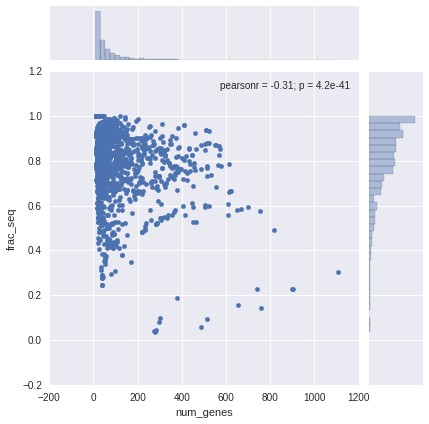

In [30]:
sns.jointplot(data = info, x = "num_genes", y = "frac_seq");

Of the 1783 unique GO terms that we will examine, most contain fewer than 200 annotated genes. It seems like most GO groups had at least 60% of their annotated genes sequenced, while some of the larger GO terms had few genes sequenced (< 20%).

---

## Modeling

We will try to fit linear and log-linear models to the drift values calculated from each GO term.

For each GO term:
1. Filter data down to just those genes
2. Calculate the drift for each sample
3. Create a regression
4. Save the results

In [31]:
def calc_drift(df):
    """Calculate drift for a gene set."""
    return (df
        .groupby(
            ["cohort", "replicate", "drug", "day_harvested", "log_day"],
            as_index = False
        )
        .agg({"RLFEC": np.var})
        .rename(columns = {"RLFEC": "drift"})
    )

In [32]:
def fit_model(df, model_type, interaction):
    """Fit a particular linear model to a drift dataframe."""
    
    R = robj.r
    R.source("../../src/fit_model.R")
    
    res = R.fit_model(df, model_type, interaction)
    
    anova_pval = res[0][0]
    adj_rsq = res[1][0]
    
    return (robj.pandas2ri.ri2py(res[2]) # the coefficient dataframe
        .reset_index()
        .rename(columns = {
            "index": "variable",
            "Estimate": "estimate",
            "Std. Error": "std_error",
            "t value": "t_value",
            "Pr(>|t|)": "p_value"
        })
        .assign(
            adj_rsq = adj_rsq,
            anova_pvalue = anova_pval,
            interaction = interaction,
            model = model_type
        )
    )

In [33]:
def model(go_id):
    """Model results for a single go term."""
    
    gene_set = annots[go_id]
    drift = calc_drift(data.query("wormbase_id in @gene_set"))
    
    res = []
    for model_type in ["linear", "loglinear"]:
        for interaction in [False, True]:
            res.append(fit_model(drift, model_type, interaction))
            
    return pd.concat(res).assign(go_id = go_id)

## Fit models to all GO terms

In [34]:
res = [model(go_term) for go_term in tqdm(info["go_id"])]

results = (pd
    .concat(res)
    .reset_index(drop = True)
    .merge(info, how = "left", on = "go_id")
)

100%|██████████| 1783/1783 [02:31<00:00, 11.77it/s]


In [35]:
results.shape

(24962, 15)

In [36]:
results.head()

,variable,estimate,std_error,t_value,p_value,adj_rsq,anova_pvalue,interaction,model,go_id,num_genes,go_name,namespace,num_seq,frac_seq
0,(Intercept),0.114700,0.027991,4.097728,0.000750,0.734092,0.16808,False,linear,GO:0007049,569,cell cycle,biological_process,493,0.866432
1,day_harvested,0.028515,0.004417,6.455497,0.000006,0.734092,0.16808,False,linear,GO:0007049,569,cell cycle,biological_process,493,0.866432
2,drugmianserin,-0.143934,0.029918,-4.810961,0.000163,0.734092,0.16808,False,linear,GO:0007049,569,cell cycle,biological_process,493,0.866432
3,(Intercept),0.092474,0.031201,2.963858,0.009143,0.750040,0.16808,True,linear,GO:0007049,569,cell cycle,biological_process,493,0.866432
4,day_harvested,0.033194,0.005371,6.180677,0.000013,0.750040,0.16808,True,linear,GO:0007049,569,cell cycle,biological_process,493,0.866432


## Save results to file

In [37]:
results.to_csv("GO_term_drift_models.tsv", sep = '\t', index = False)

---

## Loglinear results

Since the loglinear model for the filtered transcriptome fit better than the linear model, we will first examine the loglinear models.

In [38]:
logres = results.query("model == 'loglinear'")

In [39]:
logres.shape

(12481, 15)

In [40]:
logres.head()

,variable,estimate,std_error,t_value,p_value,adj_rsq,anova_pvalue,interaction,model,go_id,num_genes,go_name,namespace,num_seq,frac_seq
7,(Intercept),0.075862,0.021930,3.459227,2.997579e-03,0.865378,0.557867,False,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432
8,log(day_harvested),0.139131,0.013991,9.944497,1.679787e-08,0.865378,0.557867,False,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432
9,drugmianserin,-0.163877,0.021676,-7.560226,7.813031e-07,0.865378,0.557867,False,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432
10,(Intercept),0.070428,0.024130,2.918717,1.004299e-02,0.860096,0.557867,True,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432
11,log(day_harvested),0.143469,0.015999,8.967614,1.223218e-07,0.860096,0.557867,True,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432


### Does the interaction between time and treatment matter?

In the models for the filtered transcriptome, we saw that the interaction between time and treatment was not statistically significant, suggesting that we cannot determine if the regression lines for the two treatments had different slopes.

Let us examine whether this is also true for the GO term models.

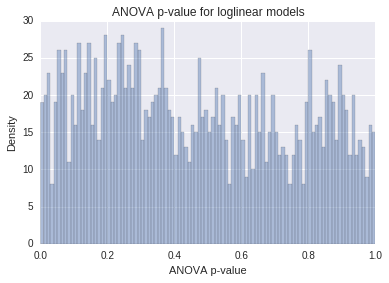

In [41]:
ax = (logres
    [["go_id", "anova_pvalue"]]
    .drop_duplicates()
    ["anova_pvalue"]
    .pipe(sns.distplot, kde = False, bins = 100)
)

ax.set_title("ANOVA p-value for loglinear models")
ax.set_ylabel("Density")
ax.set_xlabel("ANOVA p-value");

Since the distribution of the ANOVA p-value is relatively uniform across the range [0, 1], we can conclude that the interaction term between time and treatment is insignificant. Therefore we can disregard the interaction term.

### Drop the models containing the interaction term

In [42]:
logres = (logres
    .query("~interaction")
    .drop(["anova_pvalue", "interaction"], axis = 1)
    .assign(neg_log_pval = lambda df: -np.log(df["p_value"]))
)

In [43]:
logres.head()

,variable,estimate,std_error,t_value,p_value,adj_rsq,model,go_id,num_genes,go_name,namespace,num_seq,frac_seq,neg_log_pval
7,(Intercept),0.075862,0.021930,3.459227,2.997579e-03,0.865378,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432,5.809950
8,log(day_harvested),0.139131,0.013991,9.944497,1.679787e-08,0.865378,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432,17.902014
9,drugmianserin,-0.163877,0.021676,-7.560226,7.813031e-07,0.865378,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432,14.062303
21,(Intercept),0.089358,0.022706,3.935350,1.066691e-03,0.794672,loglinear,GO:0031974,522,membrane-enclosed lumen,cellular_component,488,0.934866,6.843194
22,log(day_harvested),0.106658,0.014486,7.362921,1.108465e-06,0.794672,loglinear,GO:0031974,522,membrane-enclosed lumen,cellular_component,488,0.934866,13.712535


### Examine p-value distribution for the time and treatment variables

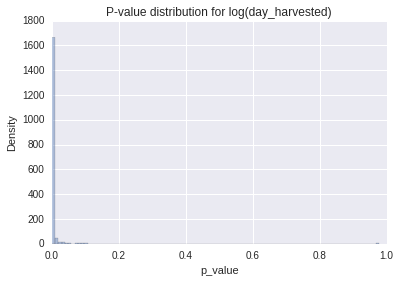

In [44]:
ax = sns.distplot(
    logres.query("variable == 'log(day_harvested)'")["p_value"],
    kde = False, bins = 100
)

ax.set_ylabel("Density")
ax.set_title("P-value distribution for log(day_harvested)");

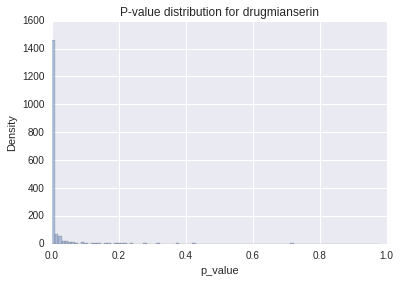

In [45]:
ax = sns.distplot(
    logres.query("variable == 'drugmianserin'")["p_value"],
    kde = False, bins = 100
)

ax.set_ylabel("Density")
ax.set_title("P-value distribution for drugmianserin");

Based on the hockey-stick shaped p-value distributions for both the time and treatment variables, we can reject the null hypothesis that the two variables are not correlated with drift.

### Volcano plots of p value vs variable

Now we can examine the coefficient estimates for both variables and the negative log of the p values.

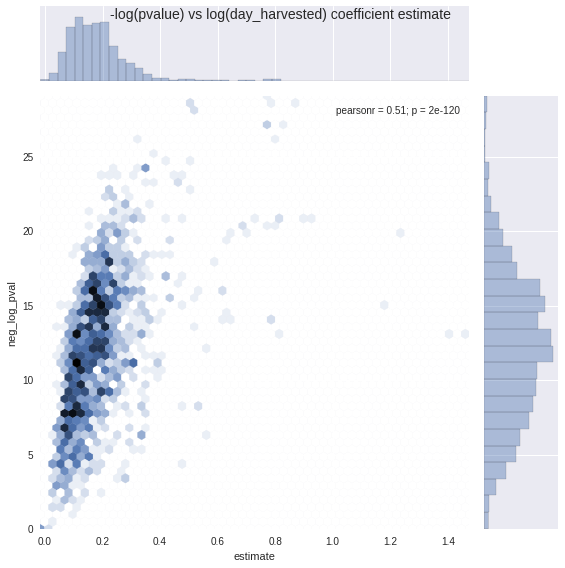

In [46]:
g = sns.jointplot(
    data = logres.query("variable == 'log(day_harvested)'"),
    x = "estimate", y = "neg_log_pval", kind = "hex", size = 8
)

g.fig.suptitle("-log(pvalue) vs log(day_harvested) coefficient estimate", fontsize = 14);

Based on this plot is seems that all GO terms had positive coefficients. Therefore no set of genes had a reduction in drift with time (became more like the young reference), which is what we expect *a priori*.

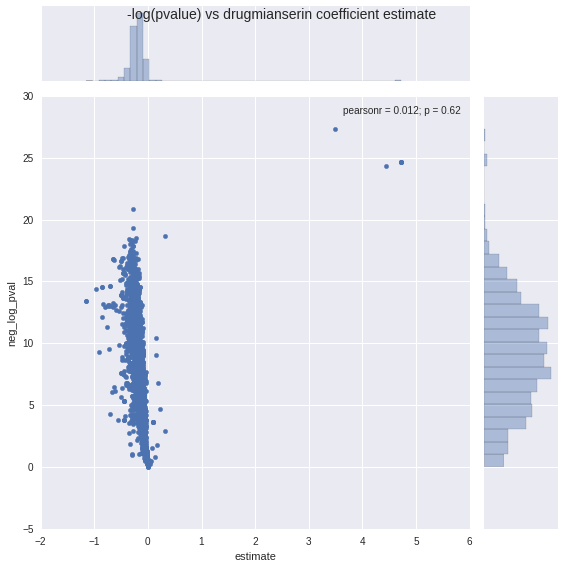

In [47]:
g = sns.jointplot(
    data = logres.query("variable == 'drugmianserin'"),
    x = "estimate", y = "neg_log_pval", kind = "scatter", size = 8
)

g.fig.suptitle("-log(pvalue) vs drugmianserin coefficient estimate", fontsize = 14);

It looks like there are extreme outliers for the mianserin effect coefficients.

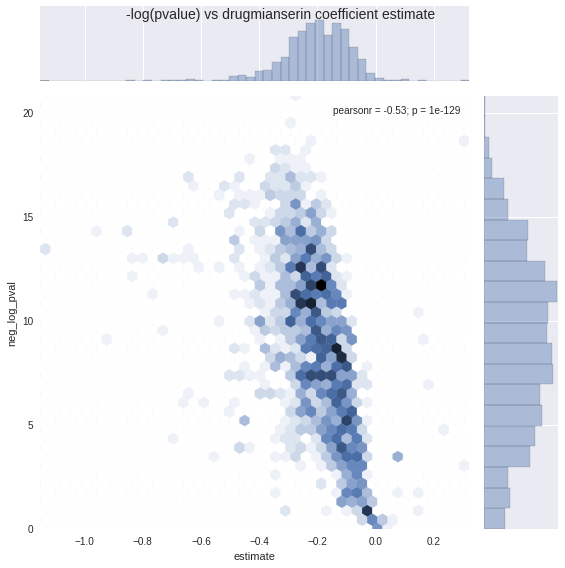

In [48]:
g = sns.jointplot(
    data = logres.query("variable == 'drugmianserin' & estimate < 1"),
    x = "estimate", y = "neg_log_pval", kind = "hex", size = 8
)

g.fig.suptitle("-log(pvalue) vs drugmianserin coefficient estimate", fontsize = 14);

When we replot, we see that the vast majority of mianserin coefficients were negative, meaning that drift was reduced when mianserin was added. However, some are positive, meaning drift increased when mianserin was added.

### R-squared vs variable p-value

Is there a correlation between the adjusted R-squared and the p values of each independent variable?

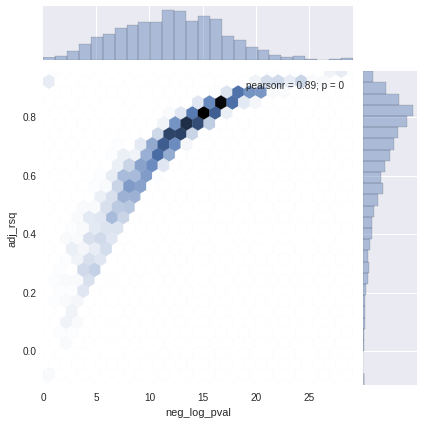

In [49]:
sns.jointplot(
    data = logres.query("variable == 'log(day_harvested)'"),
    x = "neg_log_pval", y = "adj_rsq", kind = "hex"
);

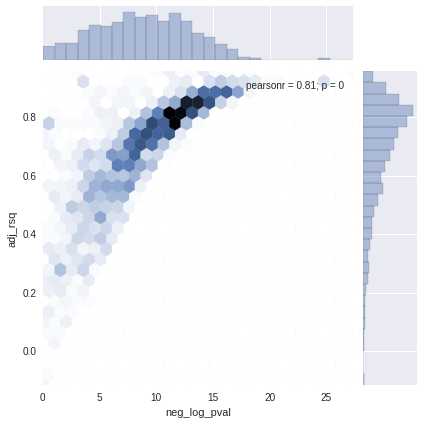

In [50]:
sns.jointplot(
    data = logres.query("variable == 'drugmianserin'"),
    x = "neg_log_pval", y = "adj_rsq", kind = "hex"
);

Based on the two plots above, it is clear that there is a correlation between the p-value estimate for each independent variable and the adjusted R-squared of the overall model. The correlation seems to be tighter for time, since the plot has less scatter.

---

### Effect of gene set size on model R-squared

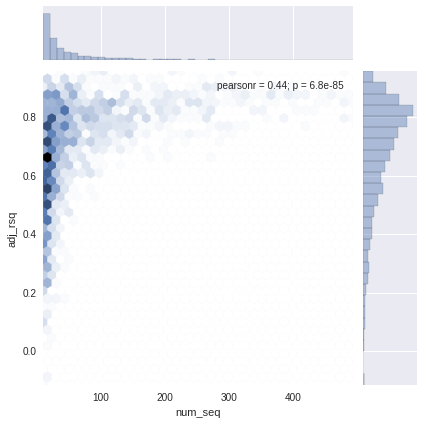

In [51]:
sns.jointplot(
    data = logres[["go_id", "num_seq", "adj_rsq"]].drop_duplicates(),
    x = "num_seq", y = "adj_rsq", kind = "hex"
);

It seems that once the number of genes in the set reaches 100, all of the models have adjusted R-squareds of at least 0.6, whereas for the GO terms with < 100 genes, there are many more bad models.

### Correlation between the two independent variables

Is there any correlation between the time and treatment variables for the linear model?

In [52]:
a = (logres
    .query("variable == 'log(day_harvested)'")
    [["go_id", "estimate", "neg_log_pval"]]
    .rename(columns = {"estimate": "day_est", "neg_log_pval": "day_pval"})
)

b = (logres
    .query("variable == 'drugmianserin'")
    [["go_id", "estimate", "neg_log_pval"]]
    .rename(columns = {"estimate": "mian_est", "neg_log_pval": "mian_pval"})
)

res = pd.merge(a, b, how = "inner", on = "go_id")

In [53]:
res.head()

,go_id,day_est,day_pval,mian_est,mian_pval
0,GO:0007049,0.139131,17.902014,-0.163877,14.062303
1,GO:0031974,0.106658,13.712535,-0.145002,12.046258
2,GO:0008219,0.161059,18.268664,-0.184409,14.017742
3,GO:0055114,0.248249,23.485863,0.151164,10.426048
4,GO:0051641,0.215581,16.160690,-0.261866,12.884774


#### Correlation of estimates

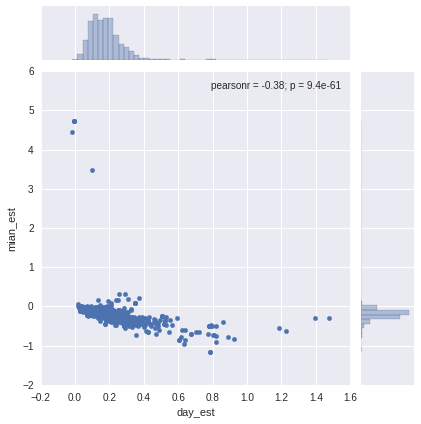

In [54]:
sns.jointplot(
    data = res,
    x = "day_est", y = "mian_est", kind = "scatter"
);

Replot with the extreme outliers filtered:

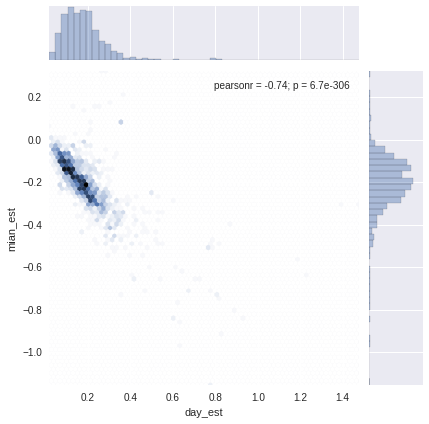

In [55]:
sns.jointplot(
    data = res.query("mian_est < 1"),
    x = "day_est", y = "mian_est", kind = "hex"
);

Seems like the greater the increase in drift with time, the larger the effect of mianserin in reducing drift.

#### Correlation of p-values

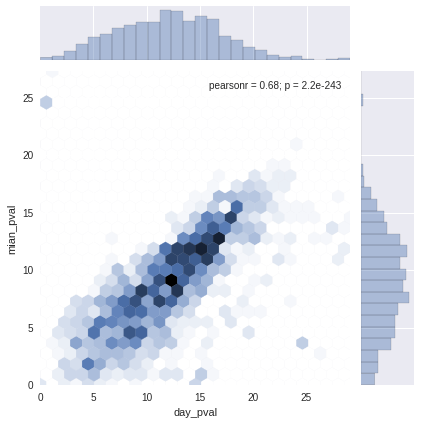

In [56]:
sns.jointplot(
    data = res,
    x = "day_pval", y = "mian_pval", kind = "hex"
);

As the p value for the effect of time becomes smaller, so does the p value for the effect of mianserin.

---

### Control for false discovery

We calculate the adjusted FDR p values for the two independent variables. The FDR is arbitrarily set of 0.1.

In [57]:
a = (logres
    .query("variable == 'log(day_harvested)'")
    [["go_id", "estimate", "std_error", "p_value"]]
    .rename(columns = lambda col: "day_{}".format(col) if col != "go_id" else col)
)

b = (logres
    .query("variable == 'drugmianserin'")
    [["go_id", "estimate", "std_error", "p_value"]]
    .rename(columns = lambda col: "mian_{}".format(col) if col != "go_id" else col)
)

res = pd.merge(a, b, how = "inner", on = "go_id").merge(logres[["go_id", "adj_rsq"]].drop_duplicates(), how = "left", on = "go_id")

In [58]:
res.head()

,go_id,day_estimate,day_std_error,day_p_value,mian_estimate,mian_std_error,mian_p_value,adj_rsq
0,GO:0007049,0.139131,0.013991,1.679787e-08,-0.163877,0.021676,7.813031e-07,0.865378
1,GO:0031974,0.106658,0.014486,1.108465e-06,-0.145002,0.022443,5.866465e-06,0.794672
2,GO:0008219,0.161059,0.015796,1.164180e-08,-0.184409,0.024474,8.169055e-07,0.869167
3,GO:0055114,0.248249,0.017312,6.312763e-11,0.151164,0.026822,2.965003e-05,0.940934
4,GO:0051641,0.215581,0.024470,9.582997e-08,-0.261866,0.037912,2.536375e-06,0.836793


In [59]:
R = robj.r
adjust = R["p.adjust"]

res["day_fdr_pvalue"] = adjust(res["day_p_value"], method = "BH")
res["mian_fdr_pvalue"] = adjust(res["mian_p_value"], method = "BH")

res = res.merge(info, how = "left", on = "go_id")

In [60]:
res.head()

,go_id,day_estimate,day_std_error,day_p_value,mian_estimate,mian_std_error,mian_p_value,adj_rsq,day_fdr_pvalue,mian_fdr_pvalue,num_genes,go_name,namespace,num_seq,frac_seq
0,GO:0007049,0.139131,0.013991,1.679787e-08,-0.163877,0.021676,7.813031e-07,0.865378,1.461005e-07,0.000007,569,cell cycle,biological_process,493,0.866432
1,GO:0031974,0.106658,0.014486,1.108465e-06,-0.145002,0.022443,5.866465e-06,0.794672,2.900275e-06,0.000024,522,membrane-enclosed lumen,cellular_component,488,0.934866
2,GO:0008219,0.161059,0.015796,1.164180e-08,-0.184409,0.024474,8.169055e-07,0.869167,1.159627e-07,0.000007,571,cell death,biological_process,486,0.851138
3,GO:0055114,0.248249,0.017312,6.312763e-11,0.151164,0.026822,2.965003e-05,0.940934,3.751886e-09,0.000078,613,oxidation-reduction process,biological_process,481,0.784666
4,GO:0051641,0.215581,0.024470,9.582997e-08,-0.261866,0.037912,2.536375e-06,0.836793,4.786301e-07,0.000014,553,cellular localization,biological_process,480,0.867993


### Save good results to file

In [61]:
res.to_csv("GO_drift_FDR_results.tsv", sep = '\t', index = False)